# Cluster users according to their activity within the app

This code takes features extracted from user login data, combined the number of events the users attended to cluster users. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Cluster-users-according-to-their-activity-within-the-app" data-toc-modified-id="Cluster-users-according-to-their-activity-within-the-app-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cluster users according to their activity within the app</a></span><ul class="toc-item"><li><span><a href="#Prepare-dataset" data-toc-modified-id="Prepare-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prepare dataset</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#Hierarchical-clustering" data-toc-modified-id="Hierarchical-clustering-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Hierarchical clustering</a></span></li><li><span><a href="#K-means" data-toc-modified-id="K-means-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>K-means</a></span></li><li><span><a href="#T-SNE" data-toc-modified-id="T-SNE-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>T-SNE</a></span></li></ul></li></ul></div>

## Prepare dataset

In [1]:
import pandas as pd
import tsfresh.utilities.dataframe_functions
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [2]:
#Load the extracted feature from the previous step 
#and also the table containing the events each user attended.
userinfo = pd.read_csv('userinfo.csv')
event = pd.read_csv('ProfileTimelineItem.csv')
user_login = pd.read_csv('user_login_new.csv',index_col = [0])

In [3]:
#Calculate the number of events each user attended.
event_att=event[event['date'] > '2019-08-01 00:00:00.000+00']
event_count = event_att['user'].value_counts()
event_sum = event_count.rename_axis('_id').reset_index(name='event_count')
#Choose date of only users
user_clu = pd.merge(userinfo, event_sum, how='outer', on=['_id'])
user_clu = user_clu[user_clu['role'] =='user']
#For users doesn't attend any events, set the number of events 0.
user_clu['event_count'].fillna(0, inplace=True)
userinfo = user_clu.iloc[:,[0,9,10,11,12,14,15,16,17,18,19,20,21,22]]
userinfo.rename(columns={'_id':'id'},inplace=True)

/Users/zhenruzhou/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [6]:
#Merge all the features
user_ret = pd.merge(user_login, userinfo, how='left', on=['id']).set_index('id')
# Drop the column that only have one value.
#Those column cannot segment the users anyway.
drop = user_ret.columns[user_ret.nunique() == 1]
temp = list(drop)
user1 = user_ret.drop(temp, axis = 1)
#Convert categorical variable into dummy/indicator variables for clustering
user_retion = pd.get_dummies(user1)
#Use impute function in tsfresh package to replace all NaNs and infs from the dataframe.
#Replace NaN with median, replace -inf with min and replace +inf with max.
user_retention = tsfresh.utilities.dataframe_functions.impute(user_retion) 

In [8]:
#Standardize the Data
x = user_retention.values
# Standardizing the features
x = StandardScaler().fit_transform(x)

## PCA

In [9]:
#Apply dimension reduction by PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

(-20, 60)

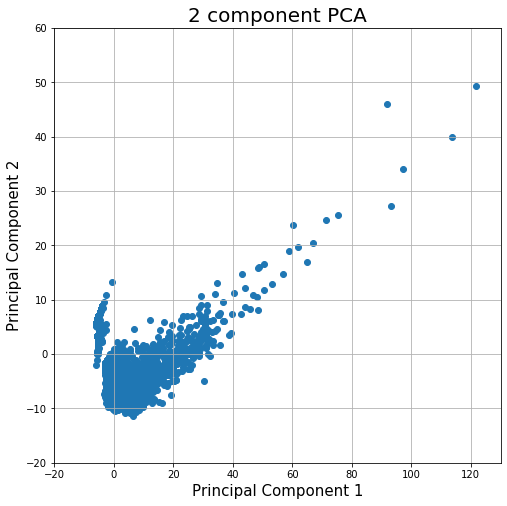

In [12]:
#Scatter plot of PCA results shows a clear separation of two clusters.
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
ax.grid()
plt.xlim(-20,130)
plt.ylim(-20,60)

## Hierarchical clustering

In [14]:
#The consulting company also just wants to separate users into two groups.
#So I decided to set the cluster number to be 2.
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = cluster.fit_predict(principalDf)

(-20, 80)

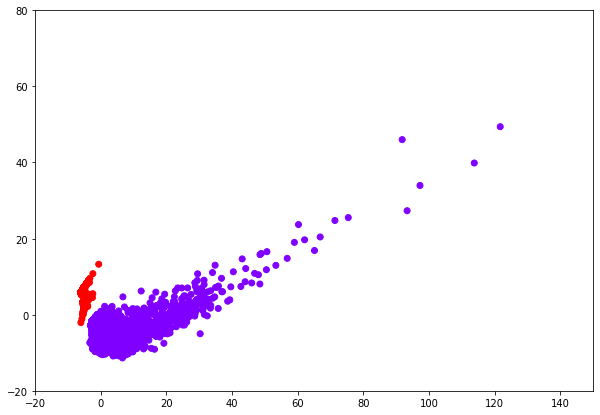

In [15]:
#The result of clustering by Hierarchical clustering algorithm.
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=cluster.labels_, cmap='rainbow')
plt.xlim(-20,150)
plt.ylim(-20,80)

In [16]:
#Save the labels of the users
user_retention['clusters'] = labels
user_la = user_retention.reset_index()
user_label = user_la[['id','clusters']]
user_label.to_csv('user_label_PCA.csv')

In [21]:
#Went back to the original data to do sanity check.
#'event_count' is average of the number of events each cluster of users attended.
#'interval' is average of the duration of app usage of each cluster of users.
clmns = ['event_count','interval']
average = user_retention[clmns].groupby(user_retention['clusters']).mean()
average
#Cluster 0 attend more events and use app longer, define it as high-activity users.
#Cluster 1 attend less events and use app shorter, define it as low-activity users.

,event_count,interval
clusters,,
0,1.842879,20.565217
1,0.215030,1.341008


## K-means

In [18]:
#I also tried to cluster users by K-means.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(principalDf)
y_kmeans = kmeans.predict(principalDf)

(-20, 80)

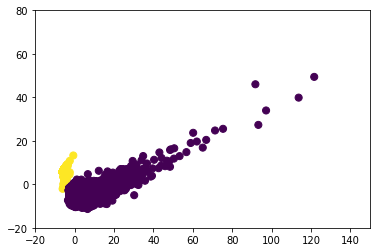

In [20]:
#The result of K-means is the same as Hierarchical clustering because the separation of two group is very clear
#So I just use the result of Hierarchical clustering.
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=y_kmeans, s=50, cmap='viridis')
plt.xlim(-20,150)
plt.ylim(-20,80)

## T-SNE

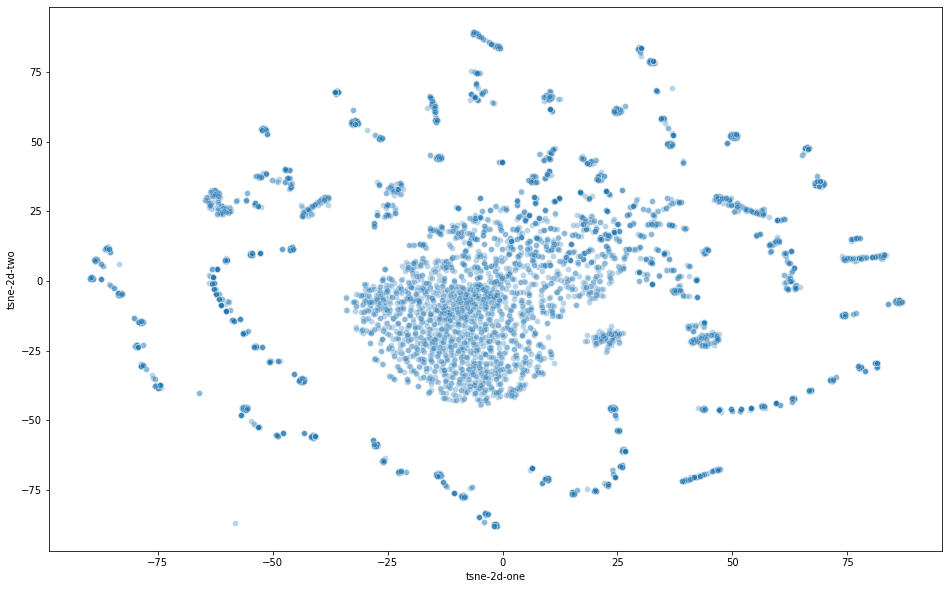

In [180]:
#I also tried to use T-SNE to visualize this high-dimensional data.
#Dimension reduction by T-SNE doesn't show clear separation of clusters in this case.
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(x)
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)